# Exploring sea ice heights with ICESat-2 (ATL07)

Information obtained primarily from the ATL07/10 Algorithm Theoretical Basis Document (ATBD, Kwok et al., 2019) and the NSIDC product description page: https://nsidc.org/data/atl07.   

* Notebook author: Ellen Buckley, heavily based on 2019 Hackweek notebook by Alek Petty, and  relying extensively on above product manuals.    
* Description: Notebook describing the ICESat-2 ATL07 product.   
* Input requirements: Demo ATL07 and ATL03 data files imported from tutorials-data folder   
* Date: June 2020
* More info: at NSIDC https://nsidc.org/data/atl07 under the Technical References tab you'll see:
    - ATL07/ATL10 Algorithm Theoretical Basis Document (ATBD)
    - the data dictionary
    - the known issues document

## Notebook objectives
* General understanding of the data included in a typical ATL07 file.
* Reading in, plotting and basic analysis of ATL07 data.
* How variables change with different surface types.
* How clouds affect surface returns


In [25]:
%matplotlib inline

In [26]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import h5py
from scipy.interpolate import interp1d
from astropy.time import Time
import readers as rd

## Select and Import Data

#### Granule Selection

Naming convention for ATL07 files: Instead of 14 regions, there are only 2: Northern Hemisphere (01), and Southern Hemisphere (02). For Northern Hemisphere products look for files that start with 'ATL07-01'

'ATL07-[HH] _ [yyyymmdd][hhmmss] _ [ttttccss]_[vvv_rr].h5'

'ATL07-01_20190324002217_13070201_002_01.h5'

#### Import Data

You can either get the data for this tutorial from the tutorial-data/sea-ice/ folder (at the hackweek) or download from NSIDC if you are running this on your local machine

In [27]:
data_loc='/home/jovyan/tutorial-data/sea-ice/'
fname='ATL07-01_20190324002217_13070201_002_01.h5'

In [28]:
f = h5py.File(data_loc+fname, 'r')
#check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
print(f['orbit_info/sc_orient'][0])

0


We are in backward orientation, left beams are strong, right are weak. Here are the ATL07 parameters we are interested in using in this notebook:

In Group: gtx/sea_ice_segments/
* latitude
* longitude
* delta_time
* seg_dist_x

In Group: gtx/sea_ice_segments/heights/
* height_segment_height
* height_segment_confidence
* height_segment_type
* height_segment_ssh_flag
* height_segment_w_gaussian

In Group: gtx/sea_ice_segments/stats/
* photon_rate
* cloud_flag_asr

In Group: gtx/sea_ice_segments/geophysical/
* height_segment_lpe
* height_segment_mss
* height_segment_ocean
* height_segment_ib


Run the getATL07 function to read the data into a pandas dataframe.

In [29]:
beam='gt1l'
df07= rd.getATL07(f,beam)
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
0,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042054
1,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042054
2,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042054
3,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042054
4,76.481384,99.577466,3.402823e+38,3.862334e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,3,-6.674923,-0.164509,-0.037621,0.042054


Use the getATL03 function from the readers script to read in the ATL03 data from the same RGT.

In [30]:
fname='ATL03_20190324004315_13070204_003_01.h5'
f = h5py.File(data_loc+fname, 'r')
beam='gt1l'
df03=rd.getATL03(f, beam)
df03.head()

,lats,lons,x,y,heights,dt,conf
0,79.993240,96.245996,8938350.0,3554.728271,-1852.795776,3.862339e+07,-1
1,79.993250,96.246020,8938351.0,3554.025879,-1772.485352,3.862339e+07,-1
2,79.993249,96.246143,8938351.0,3551.713867,-1507.922729,3.862339e+07,-1
3,79.993259,96.246068,8938352.0,3552.905273,-1644.257935,3.862339e+07,-1
4,79.993263,96.245989,8938353.0,3554.297119,-1803.527100,3.862339e+07,-1


## Surface type classification

First we want to look at the surface type classifications in ATL07 and demonstrate how the classification algorithm works.

Surface type parameter: Value that indicates segment surface type as sea ice or different types of sea surface. 

 0 cloud_covered 
 
 1 other (sea ice)
 
 2-5 specular lead : high photon rates

 6-9 dark lead : low/medium photon rate but narrow surface height distribution

#### Cut to smaller region
Using the same method as before to look at a shorter section.

In [31]:
lonmin,lonmax,latmin,latmax= [-60,0,85.52,85.57]
region=(df07.lats>latmin)&(df07.lats<latmax)&(df07.lons>lonmin)&(df07.lons<lonmax)
df07_cut=df07[region]
# cut df03 to region of interest
region=(df03.lats>latmin)&(df03.lats<latmax)&(df03.lons>lonmin)&(df03.lons<lonmax)
df03_cut=df03[region]

#### Apply vertical corrections to ATL03
A number of corrections are applied to the between ATL03 heights and ATL07 heights. To compare ATL03 and ATL07 we apply these corrections to the ATL03 data so that it has the same vertical reference as ATL07. 

We interpolate the correction values from the ATL07 parameters to the ATL03 alongtrack distance. Then we subtract those corrections from the ATL03 heights to compare with ATL07 heights. 

In [32]:
# mean sea surface correction
mss_corr=interp1d(df07.dt.values,df07.mss.values)
# inverted barometer correction
ib_corr=interp1d(df07.dt.values,df07.ib.values)
# ocean tide correction
ocean_corr=interp1d(df07.dt.values,df07.ocean.values)
# long period equilibrium tide correction
lpe_corr=interp1d(df07.dt.values,df07.lpe.values)

df03_cut['correction']=mss_corr(df03_cut.dt.values)+ib_corr(df03_cut.dt.values)+ocean_corr(df03_cut.dt.values)+lpe_corr(df03_cut.dt.values)
df03_cut['height_corr']=df03_cut.heights-df03_cut.correction
df03_cut.head()


,lats,lons,x,y,heights,dt,conf,correction,height_corr
4036701,85.569996,-46.016583,10476964.0,3531.424316,21.798777,3.862361e+07,1,19.742252,2.056525
4036702,85.569996,-46.016582,10476964.0,3531.437744,20.282537,3.862361e+07,4,19.742252,0.540286
4036703,85.569996,-46.016579,10476964.0,3531.479980,15.536215,3.862361e+07,1,19.742252,-4.206037
4036704,85.569996,-46.016582,10476964.0,3531.438477,20.189342,3.862361e+07,4,19.742252,0.447091
4036705,85.569996,-46.016582,10476964.0,3531.427002,21.481829,3.862361e+07,1,19.742252,1.739577


#### Map the region
Let's show the area that we are working with first:

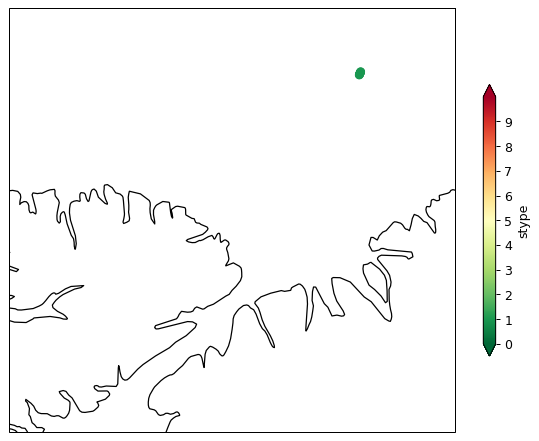

In [33]:
var= 'stype' 

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=10
ticks=np.arange(vmin,vmax,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-50)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-80,-40,80,86], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::100], df07_cut['lats'][::100],c=df07_cut[var][::100], cmap=plt.cm.get_cmap('RdYlGn').reversed(), vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

#### Subplots showing relationship between variables
Here I wanted to show the relationship between different parameters and surface type classification. The surface type classification for ATL07 segments is based on the surface photon rate, the background rate and the width of the surface photon distribution. After the radiometric classification of the surface step, a final step looks at the heights of the ATL07 segment, and ensures it is in the lowest 2% of the distribution of all segment heights wihtin 200km section, which in the case it is. So the sea surface height flag value is 1 (sea surface).
* Plot 1: Photon rate
* Plot 2: Gaussian width
* Plot 3: The ATL07 surface flag is 3: specular lead.
* Plot 4: The ATL07 sea ice segment heights on top of the ATL03 photon cloud. 
* Plot 5: Sea surface height flag. 

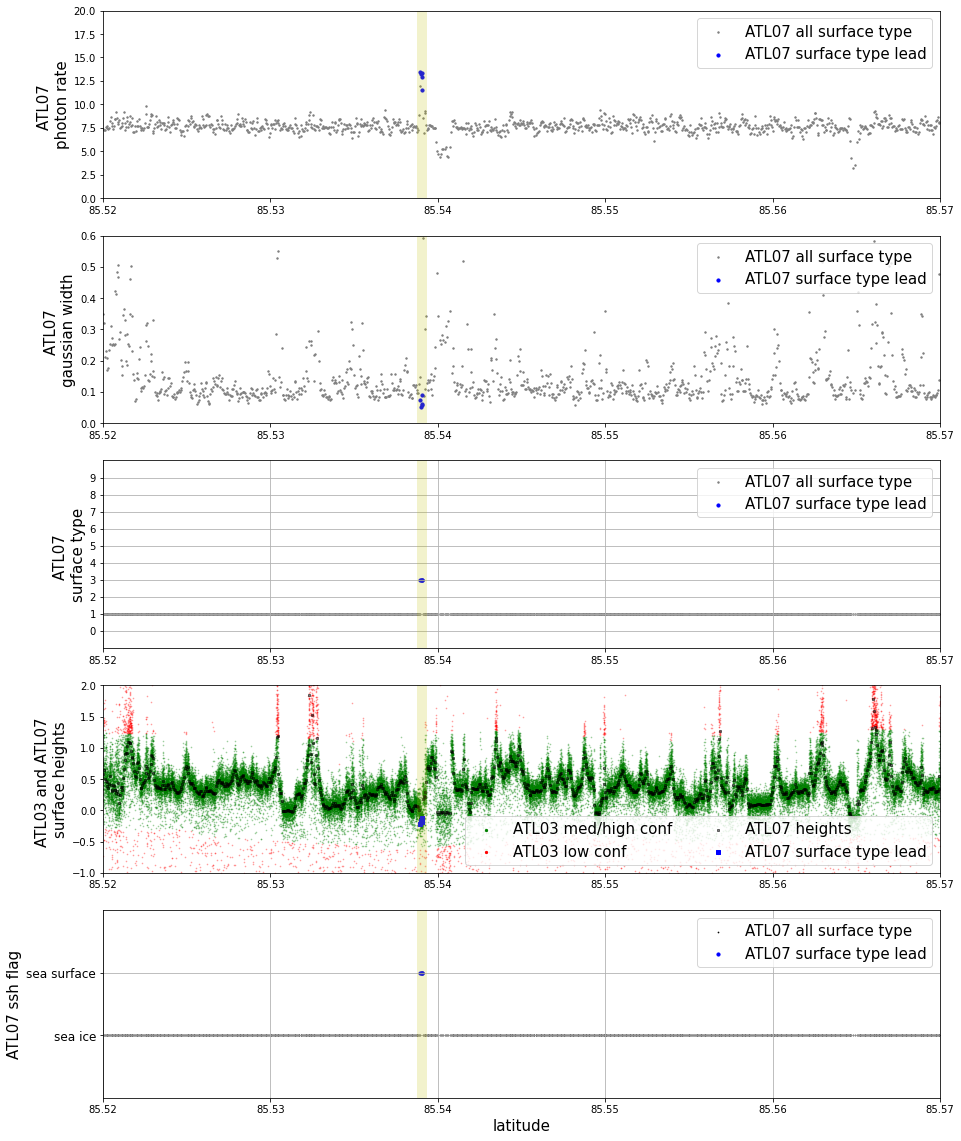

In [34]:
fig,ax=plt.subplots(5,1,figsize=(15,20))

ax[0].scatter(df07_cut.lats,df07_cut.photon_rate,s=2,c='gray', label='ATL07 all surface type')
ax[0].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].photon_rate,s=10,c='b', label= 'ATL07 surface type lead')
ax[0].legend(fontsize=15)
ax[0].set_ylim(0,20)
ax[0].set_ylabel('ATL07 \nphoton rate',fontsize=15)

ax[1].scatter(df07_cut.lats,df07_cut.gauss,s=2,c='gray', label='ATL07 all surface type')
ax[1].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].gauss,s=10,c='blue',label= 'ATL07 surface type lead')
ax[1].legend(loc=1,fontsize=15)
ax[1].set_ylabel('ATL07 \ngaussian width',fontsize=15)
ax[1].set_ylim(0,.6)

ax[2].grid()
ax[2].scatter(df07_cut.lats,df07_cut.stype,s=2,c='gray',label='ATL07 all surface type')
ax[2].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].stype,s=10,c='blue',label= 'ATL07 surface type lead')
ax[2].legend(fontsize=15)
ax[2].set_ylim(-1,10)
ax[2].set_ylabel('ATL07 \nsurface type',fontsize=15)
ax[2].set_yticks(np.arange(0,10,1))

ax[3].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.height_corr[df03_cut.conf<3],c='r',s=.5,alpha=.3)
ax[3].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.height_corr[df03_cut.conf>2],c='g',s=.5,alpha=.3)
ax[3].scatter(0,0,c='g',s=5,alpha=1, label = 'ATL03 med/high conf')
ax[3].scatter(0,0,c='r',s=5,alpha=1, label= "ATL03 low conf")

ax[3].scatter(df07_cut.lats,df07_cut.heights,marker='s',s=5,c='k',alpha=.5, label= 'ATL07 heights')
ax[3].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].heights,marker='s',s=10,c='b', label= 'ATL07 surface type lead')
ax[3].legend(ncol=2, loc=4,fontsize=15)
ax[3].set_ylim(-1,2)
ax[3].set_ylabel('ATL03 and ATL07 \nsurface heights',fontsize=15)

ax[4].scatter(df07_cut.lats,df07_cut.ssh_flag,c='k',s=2,marker='.',label='ATL07 all surface type')
ax[4].scatter(df07_cut[df07_cut.stype>1].lats,df07_cut[df07_cut.stype>1].ssh_flag,c='b',s=10,label='ATL07 surface type lead')
ax[4].legend(fontsize=15)
ax[4].grid()
ax[4].set_ylim(-1,2)
ax[4].set_yticks(np.arange(0,2,1))
ax[4].set_yticklabels(['sea ice', 'sea surface'],fontsize=12)
ax[4].set_ylabel('ATL07 ssh flag',fontsize=15)

ax[4].set_xlabel('latitude',fontsize=15)

for a in np.arange(0,5):
    ax[a].set_xlim(latmin,latmax)
    ax[a].axvline(df07_cut[df07_cut.ssh_flag==1].lats.values[0],c='y',alpha=.2, linewidth=10)



## Impact of Clouds on Data

Here we are looking at the cloud flag. This is a useful parameter if you want to filter the data. We investigate a section of data that transitions from clear to cloudy and see how that impacts the parameters in ATL07 and ATL03.

In [35]:
data_loc='/home/jovyan/tutorial-data/sea-ice/'
fname='ATL07-01_20190430080720_04900301_002_01.h5'

In [36]:
f = h5py.File(data_loc+fname, 'r')
# check to see if it is forward (1)  or backward (0) orientation to know which beam is strong/weak
# (2 is transition phase- don't use these data)
print(f['orbit_info/sc_orient'][0])

0


In [37]:
beam='gt1l'
df07=rd.getATL07(f,beam)
df07.head()

,lats,lons,heights,dt,conf,stype,ssh_flag,gauss,photon_rate,cloud,mss,ocean,lpe,ib
0,64.630882,-38.745903,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.422905,-0.298257,-0.005585,-0.051556
1,64.632848,-38.746144,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.417488,-0.298275,-0.005586,-0.051655
2,64.657136,-38.749144,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.357327,-0.298487,-0.005589,-0.052876
3,64.687398,-38.752883,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.284157,-0.298747,-0.005594,-0.054403
4,64.687398,-38.752883,3.402823e+38,4.184786e+07,3.402823e+38,1,0,3.402823e+38,3.402823e+38,5,46.284157,-0.298747,-0.005594,-0.054403


#### Map cloud data

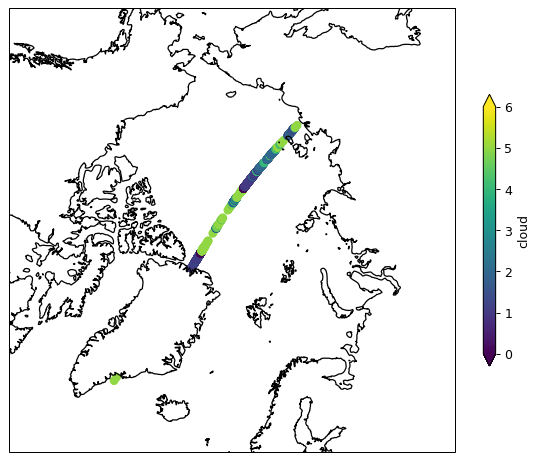

In [38]:
var= 'cloud' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=6
ticks=np.arange(vmin,vmax+1,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
plt.scatter(df07['lons'][::100], df07['lats'][::100],c=df07[var][::100], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())#plt.cm.get_cmap('RdYlGn').reversed()
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='both');

The cloud parameter ranges from 0 to 6 and is from the ATL09 atmosphere product:
* 0: high confidence clear
* 1: medium confidence clear
* 2: low confidence clear
* 3: low confidence cloudy
* 4: medium confidence cloudy
* 5: high confidence cloudy
* 6: unknown

#### How do clouds affect parameters?
We will look at the photon rate parameter. The average number of photons returned per shot over a segment.We are looking at a smaller region that has cloudy and clear data.

In [39]:
# cut to region that has clear and cloudy data
lonmin,lonmax,latmin,latmax= [170,180,85.6,86]
region=(df07.lats>latmin)&(df07.lats<latmax)&(df07.lons>lonmin)&(df07.lons<lonmax)
df07_cut=df07[region]

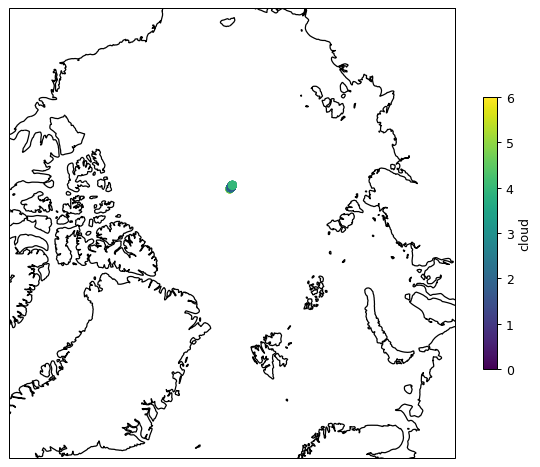

In [40]:
var= 'cloud' #choose which variable we want to plot

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=6
ticks=np.arange(vmin,vmax+1,1)


plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
plt.scatter(df07_cut['lons'][::10], df07_cut['lats'][::10],c=df07_cut[var][::10], cmap='viridis', vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
plt.colorbar(label=var, shrink=0.5, ticks=ticks,extend='neither');

#### Compare cloud flag and photon rate variables

Text(0.5, 0, 'latitude')

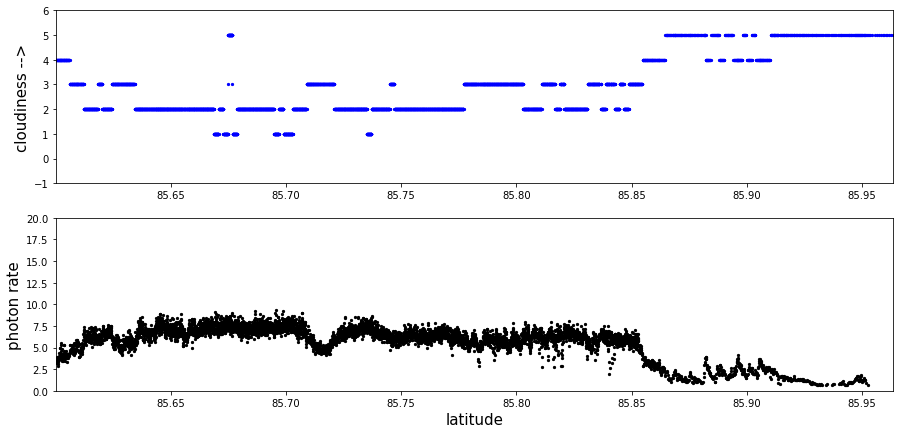

In [41]:
fig,ax=plt.subplots(2,1,figsize=(15,7))
ax[0].scatter(df07_cut.lats,df07_cut.cloud, s=5, c='b')
ax[0].set_ylabel('cloudiness -->',fontsize=15)
ax[0].set_ylim(-1,6)
ax[0].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate, s=5, c='k')
ax[1].set_ylim(0,20)
ax[1].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[1].set_ylabel('photon rate',fontsize=15)
ax[1].set_xlabel('latitude',fontsize=15)

You can see as the cloudiness increases from low/med confidence clear to high confidence cloudy, the photon rate drops.

#### Lets look at how clouds affect the ATL03 data

In [42]:
fname='ATL03_20190430082817_04900304_003_01.h5'

In [43]:
f = h5py.File(data_loc+fname, 'r')
beam='gt1l'

Use the getATL03 function to bring in the relevant ATL03 data into a pandas dataframe

In [44]:
df03=rd.getATL03(f,beam)
df03.head()

,lats,lons,x,y,heights,dt,conf
0,80.057553,-44.951288,8938431.0,-32618.839844,1626.557007,4.184809e+07,-1
1,80.057542,-44.951344,8938430.0,-32617.537109,1645.018433,4.184809e+07,-1
2,80.057577,-44.951254,8938433.0,-32619.966797,1609.915405,4.184809e+07,-1
3,80.057584,-44.951258,8938434.0,-32620.046875,1608.427856,4.184809e+07,-1
4,80.057574,-44.951349,8938433.0,-32618.103516,1635.609009,4.184809e+07,-1


In [45]:
# cut df03 to region of interest
region=(df03.lats>latmin)&(df03.lats<latmax)&(df03.lons>lonmin)&(df03.lons<lonmax)
df03_cut=df03[region]

Now we plot latitudinal sections that show the relationship between ATL07 cloudiness, photon rate, and the ATL03 surface heights

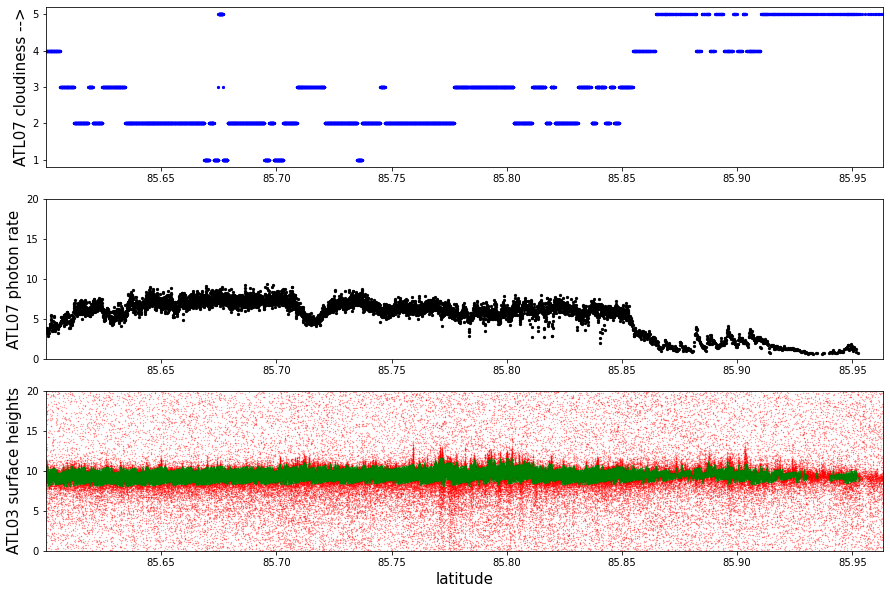

In [46]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
ax[0].scatter(df07_cut.lats,df07_cut.cloud, s=5,c='b')
ax[0].set_ylabel('ATL07 cloudiness -->',fontsize=15)
ax[0].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate, s=5,c='k')
ax[1].set_ylim(0,20)
ax[1].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[1].set_ylabel('ATL07 photon rate',fontsize=15)
ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3],c='r',s=.1,alpha=.5)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2],c='g',s=.1,alpha=.5)
ax[2].set_ylim(0,20)
ax[2].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[2].set_ylabel('ATL03 surface heights',fontsize=15)
ax[2].set_xlabel('latitude', fontsize=15);

Also note in this section you can see the solar background photons above and below the surface.

#### Zoom into that transition from clear to cloudy

In [47]:
lonmin,lonmax,latmin,latmax= [170,180,85.84,85.9]
region=(df07.lats>latmin)&(df07.lats<latmax)&(df07.lons>lonmin)&(df07.lons<lonmax)
df07_cut=df07[region]
# cut df03 to region of interest
region=(df03.lats>latmin)&(df03.lats<latmax)&(df03.lons>lonmin)&(df03.lons<lonmax)
df03_cut=df03[region]

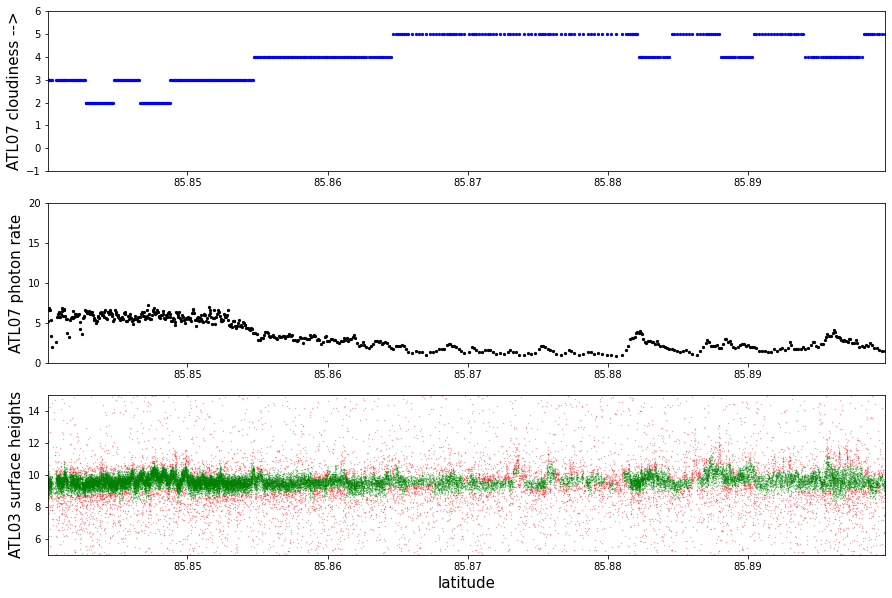

In [48]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
ax[0].scatter(df07_cut.lats,df07_cut.cloud, s=5,c='b')
ax[0].set_ylabel('ATL07 cloudiness -->',fontsize=15)
ax[0].set_ylim(-1,6)
ax[0].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[1].scatter(df07_cut.lats,df07_cut.photon_rate, s=5,c='k')
ax[1].set_ylim(0,20)
ax[1].set_ylabel('ATL07 photon rate',fontsize=15)
ax[1].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[2].scatter(df03_cut.lats[df03_cut.conf<3],df03_cut.heights[df03_cut.conf<3],c='r',s=.1,alpha=.5)
ax[2].scatter(df03_cut.lats[df03_cut.conf>2],df03_cut.heights[df03_cut.conf>2],c='g',s=.1,alpha=.5)
ax[2].set_ylim(5,15)
ax[2].set_xlim(min(df07_cut.lats),max(df07_cut.lats))
ax[2].set_ylabel('ATL03 surface heights',fontsize=15)
ax[2].set_xlabel('latitude', fontsize=15);